# Set up 

Set up of the random number generator and general libraries and configurations

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56


# Choice of data and system

Options are: the moon system (2D), the Toggle Switch (2D) and the repressilator (3D)

In [2]:
# design choices 
chosen_problem = 'repressilator'
data_noise = 0.001
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

This choice will generate autonomous dynamics


Creation of the dataset and first plot of the training data

No change  applied to TS or repr data


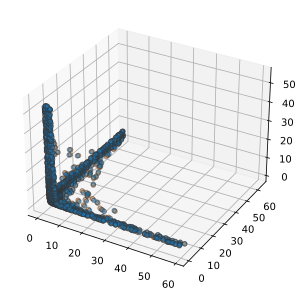

In [3]:
if problem == 'moons':
    plotlim = [-2, 3]
elif problem == 'repr':
    plotlim = [0, 60]
else:
    plotlim = [0, 2]
subfolder = str('traj_'+problem)

from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader(problem, batch_size = 3000, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

A more in depth look at the data. For data coming from ODE integration, we can check how far the target points are with respect to the input, while for the classifications problems the inputs are color coded depending on the target output. In this case, the target output needs to be known explicitely

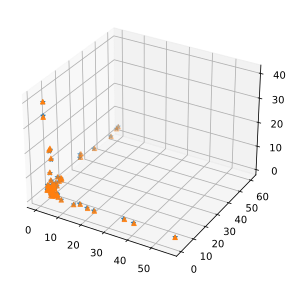

In [4]:
import matplotlib.pyplot as plt
if problem == 'repr':
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

for X_viz, y_viz in dataloader:
    x = X_viz.numpy()
    y = y_viz.numpy()
    if problem == 'repr':
        ax.scatter(x[:,0], x[:,1], x[:,2], marker = '*')
        ax.scatter(y[:,0], y[:,1], y[:,2], marker='^')
    elif problem == 'moons':
        plt.scatter(x[y[:,0]==-2,0], x[y[:,0]==-2,1], marker = '*')
        plt.scatter(x[y[:,0]==2,0], x[y[:,0]==2,1], marker = '^')
    else:
        plt.scatter(x[:,0], x[:,1], marker = '*')
        plt.scatter(y[:,0], y[:,1], marker = '^')
    plt.show()
    break

# nODE parameter choices

In [5]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, n_different_weights
bound = 0.
fp = False
cross_entropy = False
turnpike = False

# choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
# another choice is bottleneck, but I don't understand it
# non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
# architecture = 'inside' 'outside'
non_linearity = 'tanh'
architecture = 'inside'
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1}
# number of optimization runs in which the dataset is used for gradient decent
num_epochs = 80 

In [6]:
# for neural ODE based networks the network width is constant. In these examples the input is 2 or 3 dimensional
# possible_problem = {'moon':'moon', 'ToggleSwitch':'TS', 'repressilator':'repr'} 
if problem == 'moons' or problem == 'TS':
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0

In [7]:
# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

# Training

In [8]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = False, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)

Look at the parameter weights converged to during training

In [9]:
w = anode.linear_layer.weight
b = anode.linear_layer.bias
dt = anode.T/anode.time_steps   #here was no -1 before which does not fit with adjoint solver otherwise
k = int(T/dt)

architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1}
architecture_index = architectures[architecture]

for i in range(k):
    w_t = anode.flow.dynamics.fc2_time[0].weight
    b_t = anode.flow.dynamics.fc2_time[0].bias
    print('W[',i,'] =', w.detach().numpy())
    print('b[',i,'] =',b.detach().numpy())
    if architecture_index > 0:
        gam = anode.flow.dynamics.gamma[0].bias
        print('W[',i,'] =', gam.detach().numpy())

W[ 0 ] = [[ 0.11718879 -0.05638834  0.12332421]
 [ 0.23316252  0.17927484  0.19251071]
 [-0.04632004  0.00263169  0.16584586]]
b[ 0 ] = [-0.0159262 -0.3813607 -0.1200854]


Showing the classification level sets, only makes sense in 2 dimensions

In [10]:
from plots.plots import classification_levelsets
from IPython.display import Image
import os


if data_dim == 2:
    if not os.path.exists(subfolder):
            os.makedirs(subfolder)
        
    footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'

    fig_name_base = os.path.join(subfolder, 'levelsets_TS')
    classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
    
    img1 = Image(filename = fig_name_base + '.png', width = 400)
    
    display(img1)

# Dynamical insight on the repressilator

In [11]:
def repressilator(xyz, t):
    x, y, z = xyz[0], xyz[1], xyz[2]
    n = 5
    gamma, lx, ly, lz, deltax, deltay, deltaz, thetax, thetay, thetaz = 0.05, 0.01, 0.02, 0.03, 3.1, 3.2, 2.7, 1, 1.1, 1.2
    x_dot = - gamma * x + lx + deltax * thetax**n / (thetax**n + z**n)
    y_dot = - gamma * y + ly + deltay * thetay**n / (thetay**n + x**n)
    z_dot = - gamma * z + lz + deltaz * thetaz**n / (thetaz**n + y**n)
    return np.array([x_dot, y_dot, z_dot])



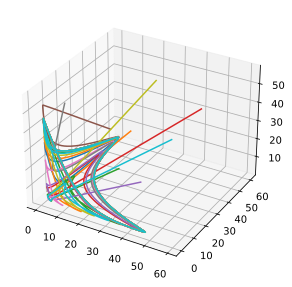

In [12]:
 import scipy

deltat = 1000
times = np.linspace(0., deltat, 3000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(10):
    x = np.random.uniform(0,60,size=3)
    y = scipy.integrate.odeint(repressilator,x,times)
    ax.plot(y[:,0], y[:,1], y[:,2])

## TO DO

1. plot the orbits of the neuralODE (use trajectory maybe?)
2. 